# Build important farmland suitablity layers for GRIDCERF


The following code was used to build the important farmland suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.5281/zenodo.6601789.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  Gridded Soil Survey Geographic (gSSURGO) Database
- **Description from Source**: The gSSURGO Database is derived from the official Soil Survey Geographic (SSURGO) Database. SSURGO generally has the most detailed level of soil geographic data developed by the National Cooperative Soil Survey (NCSS) in accordance with NCSS mapping standards. The tabular data represent the soil attributes and are derived from properties and characteristics stored in the National Soil Information System (NASIS).
- **Source URL**:  https://www.nrcs.usda.gov/resources/data-and-reports/gridded-soil-survey-geographic-gssurgo-database
- **Date Accessed**:  9/25/23
- **Citation**
> Soil Survey Staff. Gridded Soil Survey Geographic (gSSURGO) Database for the Conterminous United States. United States Department of Agriculture, Natural Resources Conservation Service. Available online at https://gdg.sc.egov.usda.gov/. September 25, 2023 (202210 official release).
- **Application**: The gSSURGO data is in the form of a geodatabase where features must be mapped to a survey raster before being exported as as shapefile. The Farmland Classification data is found under the Land Classifications SDV folder in the dataset. This data is mapped to the 30m survey raster before being downscaled to the 1000m gridcerf resolution. There are a large variety of farmland classification fields. For our suitability layers, we use the following layer information, each compiled separately:

    * <b>All areas are prime farmland </b>-  "Prime farmland is land that has the best combination of physical and chemical characteristics for producing food, feed, forage, fiber, and oilseed crops, and is also available for these uses (the land could be cropland, pastureland, rangeland, forest land, or other land, but not urban built-up land or water)."
    * <b>Farmland of unique importance </b>- "Unique farmland is land other than prime farmland that is used for the production of specific high value food and fiber crops."
    * <b>Farmland of local importance </b> - In some local areas there is concern for certain additional farmlands for the production of food, feed, fiber, forage, and oilseed crops, even though these lands are not identified as having national or statewide importance. Where appropriate, these lands are to be identified by the local agency or agencies concerned.
    * <b>Farmland of statewide importance </b>- This is land, in addition to prime and unique farmlands, that is of statewide importance for the production of food, feed, fiber, forage, and oil seed crops. Criteria for defining and delineating this land are to be determined by the appropriate State agency or agencies. Generally, additional farmlands of statewide importance include those that are nearly prime farmland and that economically produce high yields of crops when treated and managed according to acceptable farming methods.

Reference for definitions: Code of Federal Regulations. Volume: 6 Title: PART 657 - PRIME AND UNIQUE FARMLANDS Title 7 - Agriculture https://www.govinfo.gov/content/pkg/CFR-2018-title7-vol6/xml/CFR-2018-title7-vol6-part657.xml. Acessed on 05/23/23.


### 1.3 Import modules


In [1]:
import os

import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features

## 2. Configuration


In [2]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded airport data
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific",  'important_farmland')

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# template conus mask raster
conus_mask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# combined farmland classification file
farm_class_shpfile = os.path.join(source_dir, "farm_classification.shp")

# output rasters
output_prime_file = os.path.join(technology_specific_dir, "gridcerf_usda_nrsc_prime_farmland_classification.tif")
output_local_file = os.path.join(technology_specific_dir, "gridcerf_usda_nrsc_farmland_of_local_importance.tif")
output_state_file = os.path.join(technology_specific_dir, "gridcerf_usda_nrsc_farmland_of_state_importance.tif")
output_unique_file = os.path.join(technology_specific_dir, "gridcerf_usda_nrsc_farmland_of_unique_importance.tif")

# factor for converting a mile to meter
mi_to_meter = 1609.34

# crs for converting projections
crs = 'ESRI:102003'


## 4. Generate suitability rasters

### 4.1 Functions to build suitability

In [3]:
def vector_to_raster(template_raster, land_mask_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask_file = rasterio.open(land_mask_raster)
        land_mask = land_mask_file.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 4.2 Generate suitability

In [4]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

In [5]:
# read in with all farmland classification information and project to our GRIDCERF projection
gdf = gpd.read_file(farm_class_shpfile).to_crs(crs=crs)

In [6]:
# only keep areas within our GRIDCERF boundary
gdf = gpd.clip(gdf, bdf)

# add field to use for rasterization
gdf["value"] = 1

#### 4.2.1. Prime Farmland

<Axes: >

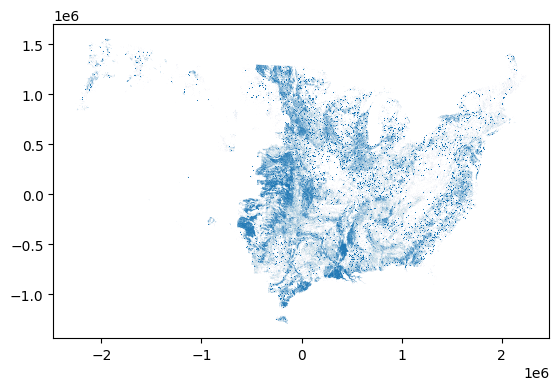

In [7]:
# split out prime farmland importance
prime_farmland_gdf = gdf[gdf.gridcode == 7]
prime_farmland_gdf.plot()

In [8]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=template_raster,
                 gdf=prime_farmland_gdf, 
                 value_field="value",
                 output_raster=output_prime_file)

#### 4.2.2. Farmland of State Importance

In [ ]:
# split out farmland of state importance
state_farmland_gdf = gdf[gdf.gridcode == 9]
state_farmland_gdf.plot()

In [ ]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=template_raster,
                 gdf=state_farmland_gdf, 
                 value_field="value",
                 output_raster=output_state_file)

#### 4.2.3. Farmland of Local Importance


In [ ]:
# split out farmland of local importance
local_farmland_gdf = gdf[gdf.gridcode == 11]
local_farmland_gdf.plot()

In [ ]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=template_raster,
                 gdf=local_farmland_gdf, 
                 value_field="value",
                 output_raster=output_local_file)

#### 4.2.4. Farmland of Unique Importance

In [ ]:
unique_farmland_gdf = gdf[gdf.gridcode == 3]
unique_farmland_gdf.plot()

In [ ]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=template_raster,
                 gdf=unique_farmland_gdf, 
                 value_field="value",
                 output_raster=output_unique_file)